# T12: Tree-Based Methods

Let's import some of our usual libraries at this top level.

In [156]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

We also collect the new imports needed for this lab.

In [157]:
from sklearn.tree import (DecisionTreeClassifier,
                          DecisionTreeRegressor,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor,
      GradientBoostingRegressor)
from ISLP.bart import BART

## Classification trees

- We first use classification trees to analyze the `Carseats` data set.
- In these data, `Sales` is a continuous variable, and so we begin by recoding it as a binary variable.
- We use the `np.where()` function to create a variable called `High`, which takes on a value of Yes if the `Sales` variable exceeds 8, and takes on a value of No otherwise.

In [158]:
Carseats = load_data('Carseats')
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [159]:
Carseats.shape

(400, 11)

In [160]:
print(Carseats[["ShelveLoc", "Urban", "US"]].describe())

       ShelveLoc Urban   US
count        400   400  400
unique         3     2    2
top       Medium   Yes  Yes
freq         219   282  258


In [161]:
# Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8,
                "Yes",
                "No")
#Carseats['High'] = High
#Carseats['High'] = Carseats['High'].astype('category')

- We now use `DecisionTreeClassifier()`  to fit a classification tree in order to predict `High` using all variables but `Sales`. To do so, we must form a model matrix as we did when fitting regression models.  

In [162]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

In [163]:
D

,CompPrice,Income,Advertising,Population,Price,ShelveLoc[Good],ShelveLoc[Medium],Age,Education,Urban[Yes],US[Yes]
0,138,73,11,276,120,0.0,0.0,42,17,1.0,1.0
1,111,48,16,260,83,1.0,0.0,65,10,1.0,1.0
2,113,35,10,269,80,0.0,1.0,59,12,1.0,1.0
3,117,100,4,466,97,0.0,1.0,55,14,1.0,1.0
4,141,64,3,340,128,0.0,0.0,38,13,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
395,138,108,17,203,128,1.0,0.0,33,14,1.0,1.0
396,139,23,3,37,120,0.0,1.0,55,11,0.0,1.0
397,162,26,12,368,159,0.0,1.0,40,18,1.0,1.0
398,100,79,7,284,95,0.0,0.0,50,12,1.0,1.0


We have converted `D` from a data frame to an array `X`, which is needed in some of the analysis below. We also need the `feature_names` for annotating our plots later.

There are several options needed to specify the  classifier,
such as `max_depth` (how deep to grow the tree), `min_samples_split`
(minimum number of observations in a node to be eligible for splitting)
and `criterion` (whether to use Gini or cross-entropy or log-loss as the split criterion).
We also set `random_state` for reproducibility; ties in the split criterion are broken at random.

In [164]:
tree_carseats = DecisionTreeClassifier(criterion='entropy',
          max_depth=3,
          random_state=0)
tree_carseats.fit(X, High)

,criterion,'entropy'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [165]:
accuracy_score(High, tree_carseats.predict(X))

0.79

- With only the default arguments, the training error rate is 21%.
- For classification trees, we can
access the value of the deviance using `log_loss()`,
\begin{equation*}
\begin{split}
-2 \sum_m \sum_k n_{mk} \log \hat{p}_{mk},
\end{split}
\end{equation*}
where $n_{mk}$ is the number of observations in the m-th terminal
node that belong to the k-th class.
- A small deviance indicates a tree that provides a good fit to the (training) dataset.

In [166]:
resid_dev = np.sum(log_loss(High, tree_carseats.predict_proba(X)))
resid_dev

np.float64(0.4710647062649358)

- This is closely related to the *entropy*. A small deviance indicates a
tree that provides a good fit to the (training) data.
 
- One of the most attractive properties of trees is that they can
be graphically displayed. Here we use the `plot()`  function
to display the tree structure.

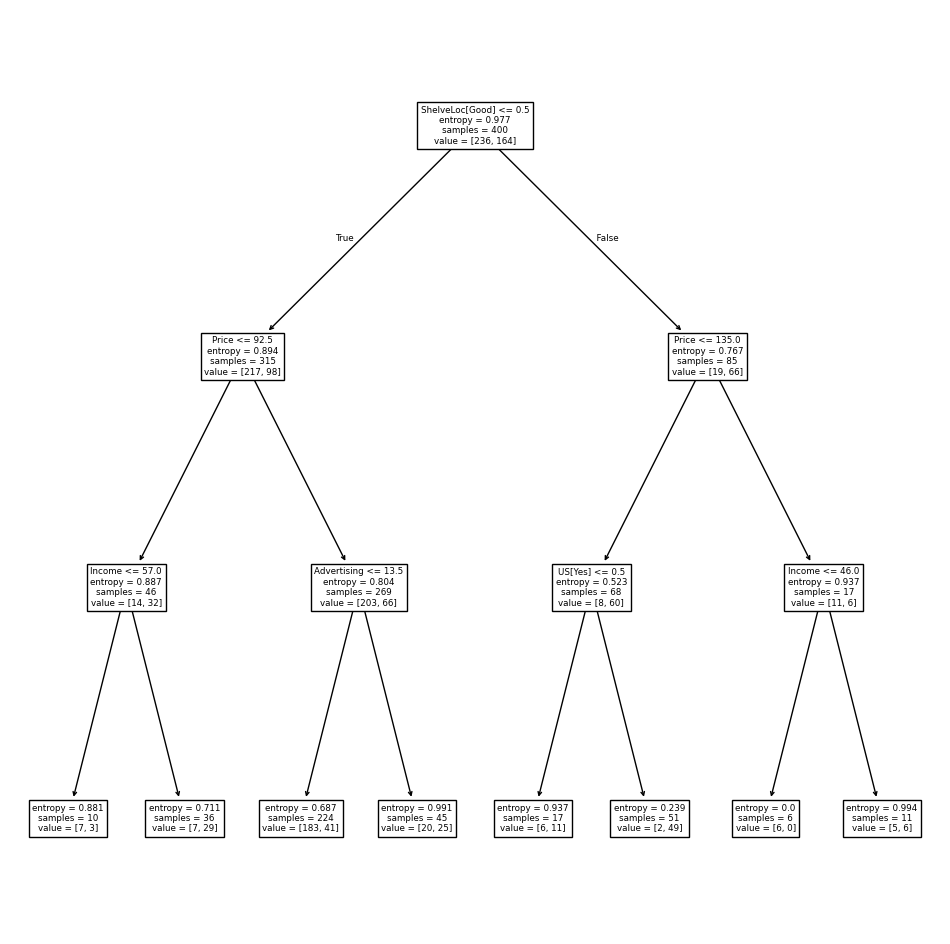

In [167]:
ax = subplots(figsize=(12,12))[1]
plot_tree(tree_carseats,
          feature_names=feature_names,
          ax=ax);

- The most important indicator of `Sales` appears to be `ShelveLoc`.

- We can see a text representation of the tree using
`export_text()`, which displays the split
criterion (e.g. `Price <= 92.5`) for each branch.

- For leaf nodes it shows the overall prediction (`Yes` or `No`). We can also see the number of observations in that leaf that take on values of `Yes` and `No` by specifying  `show_weights=True`.

In [168]:
print(export_text(tree_carseats,
                  feature_names=feature_names,
                  show_weights=True))


|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



- In order to properly evaluate the performance of a classification tree
on these data, we must estimate the test error rather than simply
computing the training error. 
- We split the observations into a
training set and a test set, build the tree using the training set,
and evaluate its performance on the test data.
- This pattern is
similar to that in Chapter 6, with the linear models
replaced here by decision trees --- the code for validation
is almost identical. This approach leads to correct predictions
for 68.5% of the locations in the test data set.

In [169]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=200,
                              random_state=0)
results = skm.cross_validate(tree_carseats,
                             D,
                             High,
                             cv=validation)
results['test_score']


array([0.685])

## * Tree pruning
​
<font color='red'>Tree pruning is not usually used in practice. So we directly skip this part. You can take a look at it if you're interested.</font>
​
- Next, we consider whether pruning the tree might lead to improved results. 
- We first split the data into a training and
test set. We will use cross-validation to prune the tree on the training
set, and then evaluate the performance of the pruned tree on the test
set..

In [170]:
(X_train,
 X_test,
 High_train,
 High_test) = skm.train_test_split(X,
                                   High,
                                   test_size=0.5,
                                   random_state=0)

- We first refit the full tree on the training set; here we do not set a `max_depth` parameter, since we will learn that through cross-validation.

In [171]:
tree_carseats = DecisionTreeClassifier(criterion='entropy', random_state=0)
tree_carseats.fit(X_train, High_train)
accuracy_score(High_test, tree_carseats.predict(X_test))

0.735

In [172]:
accuracy_score(High_train, tree_carseats.predict(X_train))

1.0

- Next we use the `cost_complexity_pruning_path()` method to extract cost-complexity values. 

In [173]:
ccp_path = tree_carseats.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)

- This yields a set of impurities and $\alpha$ values
from which we can extract an optimal one by cross-validation.

In [174]:
ccp_path

{'ccp_alphas': array([0.        , 0.01622556, 0.0171946 , 0.0180482 , 0.0180482 ,
        0.01991688, 0.02012073, 0.02070855, 0.02193427, 0.0219518 ,
        0.02220877, 0.02274806, 0.02417233, 0.02588672, 0.02714959,
        0.02735525, 0.02900052, 0.02906078, 0.03209543, 0.04499252,
        0.06236632, 0.10024835]),
 'impurities': array([0.        , 0.01622556, 0.05061477, 0.06866297, 0.08671117,
        0.12654492, 0.14666566, 0.16737421, 0.18930848, 0.21126028,
        0.25567782, 0.27842588, 0.32677055, 0.35265727, 0.43410604,
        0.54352706, 0.57252758, 0.65970991, 0.72390076, 0.8138858 ,
        0.87625212, 0.97650047])}

In [175]:
grid = skm.GridSearchCV(tree_carseats,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_

np.float64(0.685)

Let’s take a look at the pruned true.

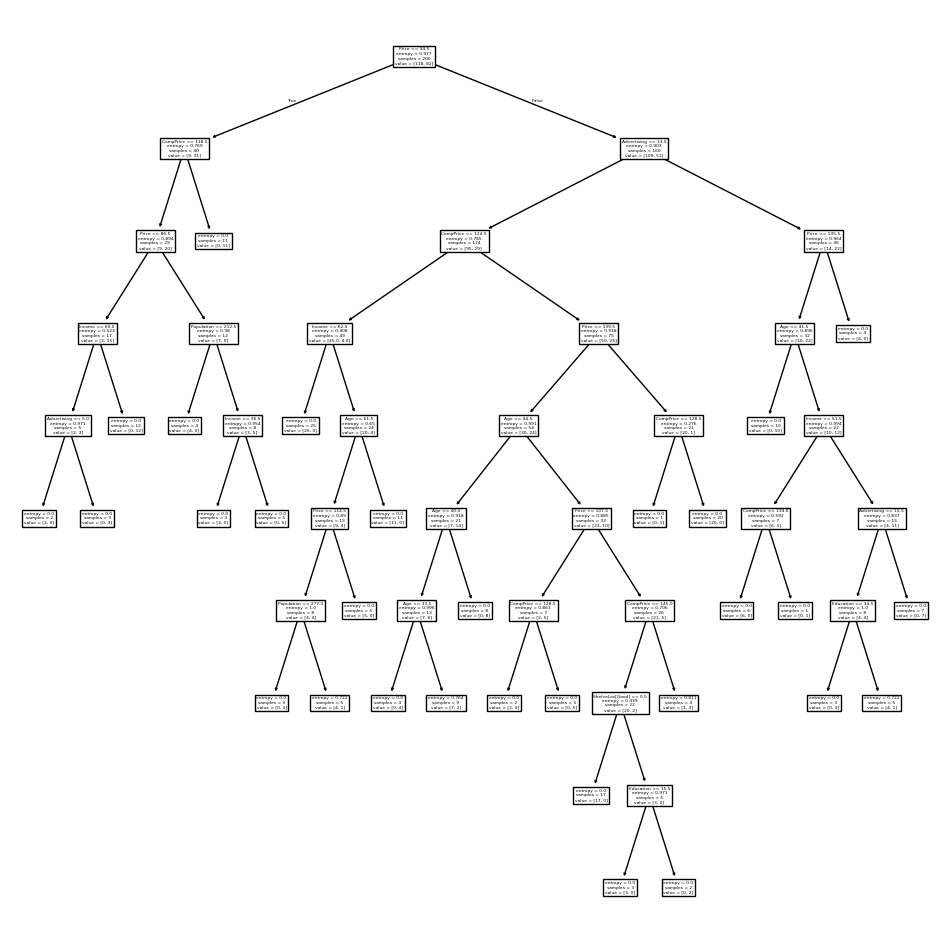

In [176]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax);

- This is quite a bushy tree. We could count the leaves, or query
`best_` instead.

In [177]:
best_.tree_.n_leaves

np.int64(30)

- The tree with 30 terminal
nodes results in the lowest cross-validation error rate, with an accuracy of
68.5%. How well does this pruned tree perform on the test data set? Once
again, we apply the `predict()`  function.

In [178]:
print(accuracy_score(High_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            High_test)
confusion

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


- Now 72.0% of the test observations are correctly classified, which is slightly worse than the error for the full tree (with 35 leaves). 
- So cross-validation has not helped us much here; it only pruned off 5 leaves, at a cost of a slightly worse error. 
- These results would change if we were to change the random number seeds above; even though cross-validation gives an unbiased approach to model selection, it does have variance.

## Regression trees

- Here we fit a regression tree to the `Boston` data set.  The steps are similar to those for classification trees.

In [179]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [180]:
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [181]:
Boston.shape

(506, 13)

- First, we create a training set and fit the tree to the training data. Here we use half of the data for the test set.

In [182]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Boston['medv'],
                                test_size=0.5,
                                random_state=0)

- Having formed  our training  and test data sets, we fit the regression tree.

In [183]:
tree_boston = DecisionTreeRegressor(max_depth=3, random_state=0)
tree_boston.fit(X_train, y_train)
y_hat = tree_boston.predict(X_test)
np.mean((y_test - y_hat)**2)

np.float64(26.02323085009744)

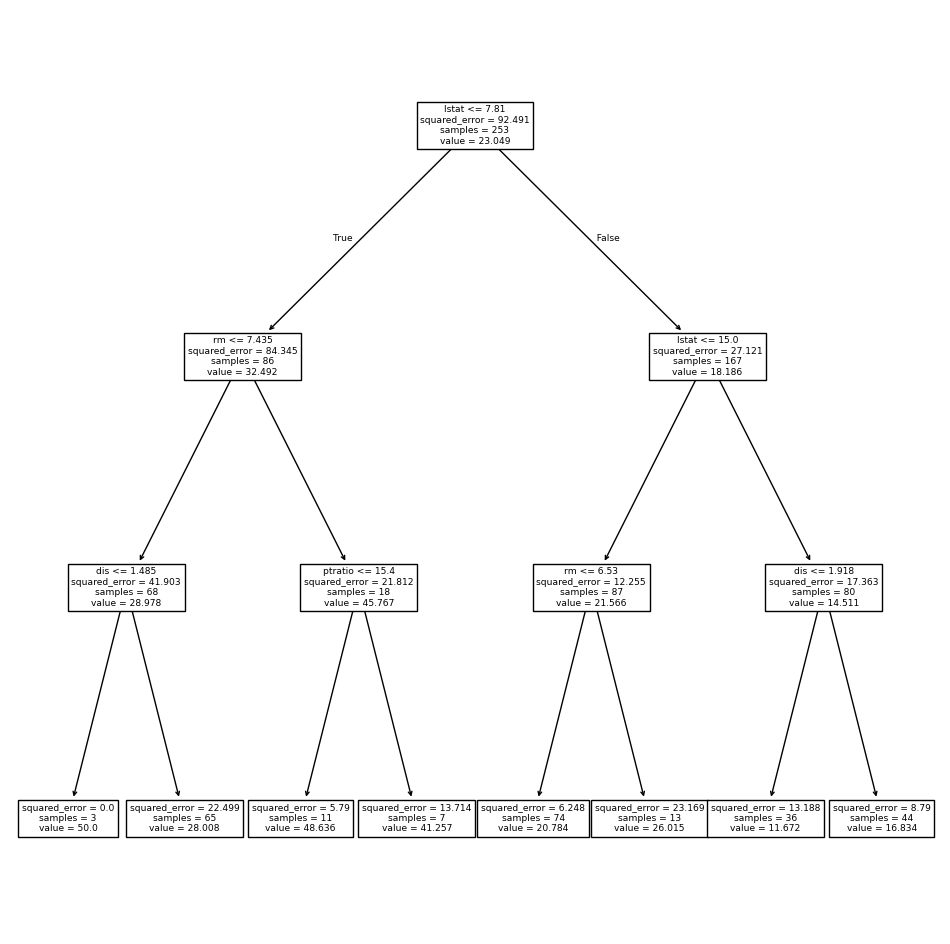

In [184]:
ax = subplots(figsize=(12,12))[1]
plot_tree(tree_boston,
          feature_names=feature_names,
          ax=ax);

- The variable `lstat` measures the percentage of individuals with
lower socioeconomic status. The tree indicates that lower
values of `lstat` correspond to more expensive houses.

- In the context of a regression tree, deviance is simply the sum of squared errors for the tree. 

- Now we use the cross-validation function to see whether pruning
the tree will improve performance.

In [185]:
tree_boston = DecisionTreeRegressor(random_state=0)
tree_boston.fit(X_train, y_train)
np.mean((y_test - tree_boston.predict(X_test))**2)

np.float64(26.375494071146246)

In [186]:
tree_boston = DecisionTreeRegressor(random_state=0)
tree_boston.fit(X_train, y_train)
ccp_path = tree_boston.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(tree_boston,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

- In keeping with the cross-validation results, we use the pruned tree
to make predictions on the test set.

In [187]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

np.float64(23.46783371326475)

- The test MSE decreases

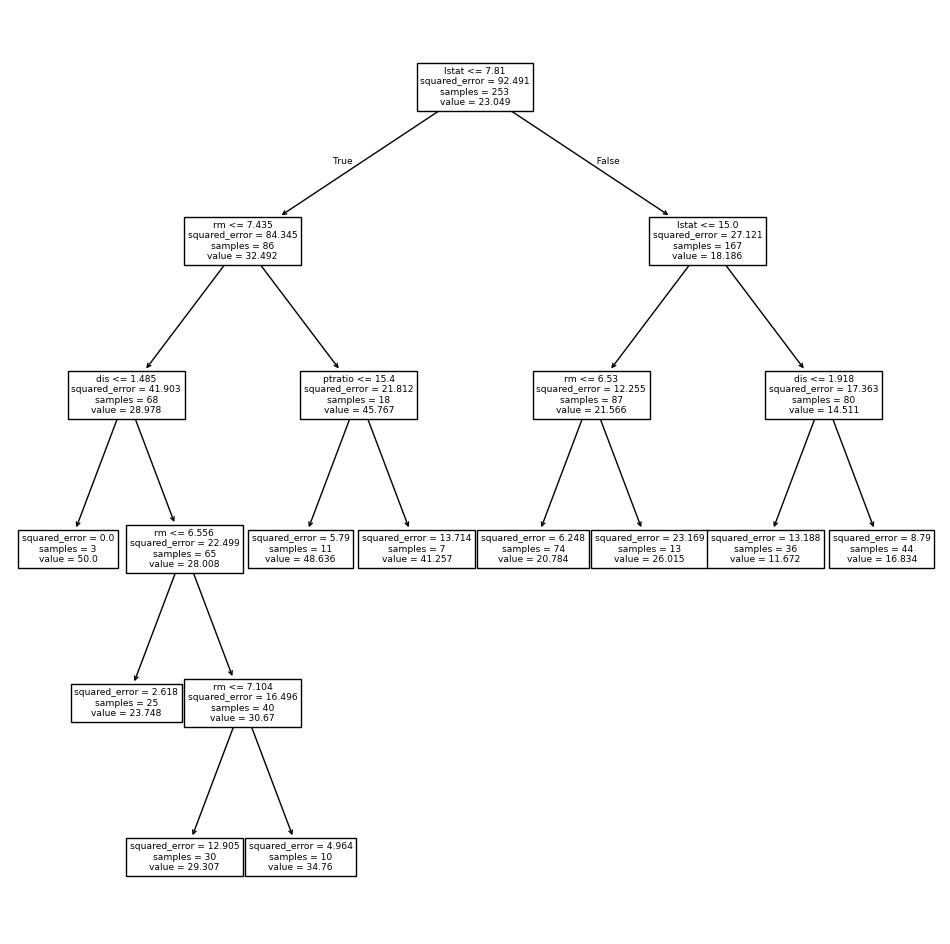

In [196]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);

## Bagging and Random Forest
- Here we apply bagging and random forests to the `Boston` dataset using
the `RandomForestRegressor()` from the `sklearn.ensemble` package. 
- Recall that bagging is simply a special case of a random forest with $m = p$. 
- Therefore, the `RandomForestRegressor()` function can be used to perform both random forests and bagging. 
- We perform bagging as follows:

In [197]:
bag_boston = RandomForestRegressor(max_features=X_train.shape[1], n_estimators=100, random_state=0)
bag_boston.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,12
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


- The argument `max_features` indicates that all 12 predictors should
be considered for each split of the tree --- in other words, that
bagging should be done.  
- How well does this bagged model perform on
the test set?

np.float64(16.069273003952564)

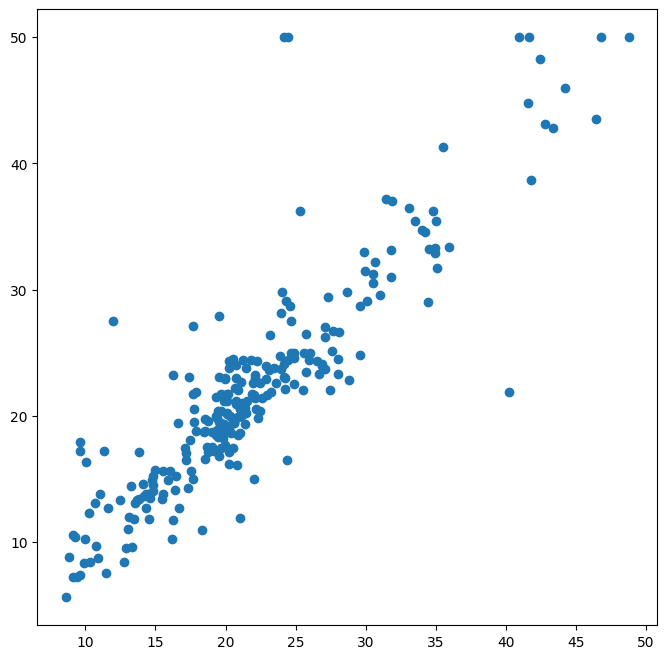

In [198]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

- The test set MSE associated with the bagged regression tree is
16.07, less than that obtained using an optimally-pruned single
tree.  
- We could change the number of trees grown from the default of 100 by
using the `n_estimators` argument:

In [199]:
bag_boston = RandomForestRegressor(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

np.float64(16.224412389881447)

- There is not much change. Bagging and random forests cannot overfit by
increasing the number of trees, but can underfit if the number is too small.

- Growing a random forest proceeds in exactly the same way, except that
we use a smaller value of the `max_features` argument. By default,
`RandomForestRegressor()`  uses $p$ variables when building a random
forest of regression trees (i.e. it defaults to bagging), and `RandomForestClassifier()` uses
$\sqrt{p}$ variables when building a
random forest of classification trees. 
- Here we use `max_features=3`.

In [200]:
RF_boston = RandomForestRegressor(max_features=3, n_estimators=100,  
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

np.float64(15.392105604743081)

- The test set MSE is 15.39
- Extracting the `feature_importances_` values from the fitted model, we can view the
importance of each variable.

In [201]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.290171
rm,0.273434
ptratio,0.076950
nox,0.071681
crim,0.069488
dis,0.056786
indus,0.049620
tax,0.040861
age,0.033901
zn,0.017891


- This is a relative measure of the total decrease in node impurity that results from
splits over that variable, averaged over all trees. 

- The results indicate that across all of the trees considered in the
random forest, the wealth level of the community (`lstat`) and the
house size (`rm`) are by far the two most important variables.

## * Random Forest: Randomization and regularization

Here we take a close look at why the randomized splitting procedure in random forest often improves prediction. 
We will see that the randomization has the regularization effect, as demonstrated by analyzing the __degrees of freedom__.

In [202]:
n = 100 # number of observations
p = 10 # number of predictors
s = 5 # number of nonzero coefficients
SNR = 1 # signal to noise ratio
nrep = 10 # number of repetitions

X = np.random.normal(size=(n, p))

beta = np.zeros(p)
beta[:s] = 1

y0 = X.dot(beta)

sige = np.sum(beta**2) / SNR

mtry_all = np.array([0.1, 0.3, 0.5, 0.7, 1]) * p
# The 'max_leaf_nodes' parameter of RandomForestRegressor must be an int in the range [2, inf) or None.
# So we change the first element of nodes_all from 1 to 2.
nodes_all = np.array([2, 5, 10, 15, 20])
out = pd.DataFrame()

for i in range(nrep):
    y = y0 + np.random.normal(0, np.sqrt(sige), n)
    for j in range(len(mtry_all)):
        for k in range(len(nodes_all)):
            fit_rf = RandomForestRegressor(n_estimators=100, max_features=int(mtry_all[j]), max_leaf_nodes=nodes_all[k])
            fit_rf.fit(X, y)
            df = np.cov(y, fit_rf.predict(X)) / sige
            out = pd.concat([out, pd.DataFrame({'df': df[0,1], 'mtry': f"mtry={mtry_all[j]}", 'maxnodes': nodes_all[k]}, index=[0])], ignore_index=True)
            print(f"{i+1}-th repetition, {j+1}-th mtry, {k+1}-th node finished.")

1-th repetition, 1-th mtry, 1-th node finished.
1-th repetition, 1-th mtry, 2-th node finished.
1-th repetition, 1-th mtry, 3-th node finished.
1-th repetition, 1-th mtry, 4-th node finished.
1-th repetition, 1-th mtry, 5-th node finished.
1-th repetition, 2-th mtry, 1-th node finished.
1-th repetition, 2-th mtry, 2-th node finished.
1-th repetition, 2-th mtry, 3-th node finished.
1-th repetition, 2-th mtry, 4-th node finished.
1-th repetition, 2-th mtry, 5-th node finished.
1-th repetition, 3-th mtry, 1-th node finished.
1-th repetition, 3-th mtry, 2-th node finished.
1-th repetition, 3-th mtry, 3-th node finished.
1-th repetition, 3-th mtry, 4-th node finished.
1-th repetition, 3-th mtry, 5-th node finished.
1-th repetition, 4-th mtry, 1-th node finished.
1-th repetition, 4-th mtry, 2-th node finished.
1-th repetition, 4-th mtry, 3-th node finished.
1-th repetition, 4-th mtry, 4-th node finished.
1-th repetition, 4-th mtry, 5-th node finished.
1-th repetition, 5-th mtry, 1-th node fi

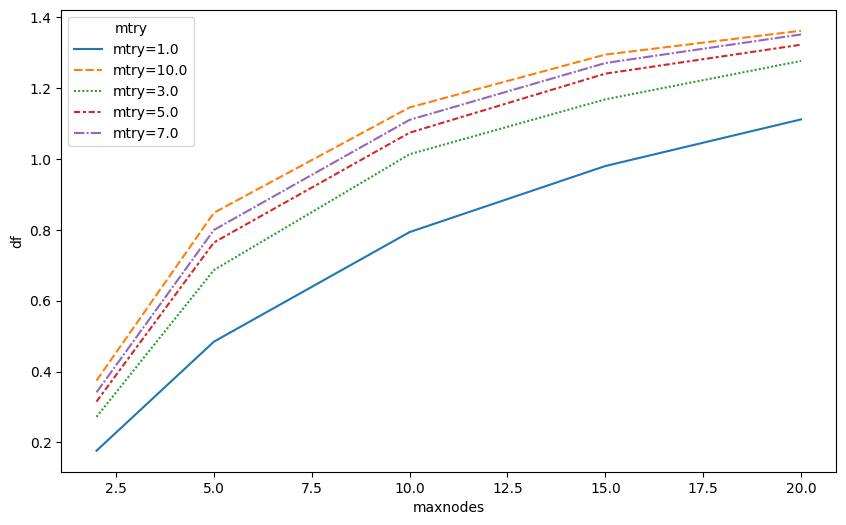

In [203]:
import seaborn as sns
import matplotlib.pyplot as plt

out1 = out.groupby(['mtry', 'maxnodes']).mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='maxnodes', y='df', hue='mtry', style='mtry', data=out1)
plt.xlabel('maxnodes')
plt.ylabel('df')
plt.show()